1. Import and setup

In [1]:
# Import necessary libraries for file handling, image processing, machine learning, and visualization
import os
import glob
import random
import cv2 as cv
import pandas as pd
import numpy as np
from tqdm import tqdm  # Progress bar for loops
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# Import TensorFlow and Keras components for building and training the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, Sequential, Model, Input
from sklearn.model_selection import train_test_split  # For splitting data into train/validation sets
from sklearn.preprocessing import LabelEncoder  # For encoding categorical labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, classification_report  # For evaluation metrics
import warnings
import joblib  # For saving the label encoder

# Suppress TensorFlow warnings to reduce console clutter
warnings.filterwarnings("ignore")

# Set random seed for reproducibility across runs
random.seed(45)

# Allow PIL to load truncated images (handles corrupted image files)
ImageFile.LOAD_TRUNCATED_IMAGES = True

2. Configuration and Constants

In [2]:
# Define configuration constants
batch_size = 32  # Batch size for training (smaller for memory efficiency)
img_height = 256  # Height of input images
img_width = 256   # Width of input images

# Define file paths for training, testing, and model saving
HOME_PATH = os.getcwd() + "/"  # Current working directory
TRAIN_IMG_PATH = HOME_PATH + 'train_images'  # Directory containing training images
TEST_IMG_PATH = HOME_PATH + 'test_images'    # Directory containing test images
META_TRAIN_PATH = HOME_PATH + 'meta_train.csv'  # Path to metadata CSV
CHECKPOINT_MODEL_PATH = HOME_PATH + 'task1/best_vit_label_model.keras'  # Path to save best model
FINAL_MODEL_PATH = HOME_PATH + 'paddy_models/vit_label_model.keras'     # Path to save final model
FINAL_WEIGHTS_PATH = HOME_PATH + 'paddy_models/vit_label_weights.weights.h5'  # Path to save model weights

# Create directory for saving models if it doesn't exist
os.makedirs('paddy_models', exist_ok=True)

3. Loading and Preparing Metadata

In [ ]:
# Load metadata from CSV file containing image IDs and labels
print("Loading metadata...")
meta_train = pd.read_csv(META_TRAIN_PATH)

# Display the number of unique labels and their names for verification
unique_labels = meta_train['label'].unique()
num_labels = len(unique_labels)
print(f"Number of unique labels: {num_labels}")
print(f"labels: {unique_labels}")

# Encode labels as integers for model training
label_encoder = LabelEncoder()
label_labels = label_encoder.fit_transform(meta_train['label'])  # Transform labels to numeric indices
label_to_idx = {label: idx for idx, label in enumerate(label_encoder.classes_)}  # Dictionary mapping labels to indices

# Save the label encoder for use during inference
joblib.dump(label_encoder, 'encoder/disease_label_encoder.joblib')

Loading metadata...
Number of unique labels: 10
labels: ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']


['label_label_encoder.joblib']

4. Creating File DataFrame

In [4]:
# Function to create a DataFrame with image file paths and encoded labels
def create_file_df(meta_df):
    """Create a DataFrame with file paths and label indices.
    Args:
        meta_df: DataFrame containing image IDs and labels.
    Returns:
        DataFrame with columns: file_path, label_label, label_name, image_id.
    """
    data = []
    # Iterate through metadata to construct image paths and collect valid files
    for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Processing images"):
        image_id = row['image_id']
        label = row['label']  # Disease/variety label (used as folder name)
        img_path = os.path.join(TRAIN_IMG_PATH, label, image_id)  # Construct full image path
        
        # Check if the image file exists before adding to dataset
        if os.path.exists(img_path):
            data.append({
                'file_path': img_path,
                'label_label': label_to_idx[label],  # Encoded label
                'label_name': label,                 # Original label name
                'image_id': image_id                 # Image filename
            })
    
    return pd.DataFrame(data)

# Create the file DataFrame for training images
print("Creating file DataFrame...")
file_df = create_file_df(meta_train)

# Split data into training (70%) and validation (30%) sets, stratified by label
train_df, val_df = train_test_split(
    file_df, 
    test_size=0.3, 
    random_state=42, 
    stratify=file_df['label_label']  # Ensure class distribution is maintained
)

Creating file DataFrame...


Processing images: 100%|██████████| 10407/10407 [00:01<00:00, 10241.86it/s]


5. ViT Hyperparameters

In [5]:
# Define model parameters
num_classes = num_labels  # Number of output classes (paddy varieties)
input_shape = (256, 256, 3)  # Input image shape (height, width, channels)

# Vision Transformer (ViT) hyperparameters
learning_rate = 0.001  # Initial learning rate for optimizer
weight_decay = 0.0001  # Weight decay for regularization
num_epochs = 50       # Maximum number of training epochs
image_size = 72        # Size to resize images for ViT (Note: differs from img_height!)
patch_size = 6         # Size of patches for ViT (6x6 pixels)
num_patches = (image_size // patch_size) ** 2  # Total number of patches
projection_dim = 64    # Dimension of patch embeddings
num_heads = 4          # Number of attention heads in transformer
transformer_units = [projection_dim * 2, projection_dim]  # Units in transformer MLP
transformer_layers = 8  # Number of transformer blocks
mlp_head_units = [2048, 1024]  # Units in final classification MLP

6. Creating TensorFlow Datasets

In [6]:
# Function to parse and preprocess images for TensorFlow dataset
def parse_image(file_path, label):
    """Load and preprocess an image from file path.
    Args:
        file_path: Path to the image file.
        label: Corresponding label (integer).
    Returns:
        Tuple of (preprocessed image, label).
    """
    image = tf.io.read_file(file_path)  # Read image file
    image = tf.io.decode_jpeg(image, channels=3)  # Decode JPEG image
    image = tf.image.resize(image, [img_height, img_width])  # Resize to specified dimensions
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0,1]
    return image, label

# Function to create a TensorFlow dataset from a DataFrame
def create_dataset(df, batch_size=32, is_training=True):
    """Create a TensorFlow dataset from DataFrame.
    Args:
        df: DataFrame with file paths and labels.
        batch_size: Number of samples per batch.
        is_training: If True, shuffle and repeat dataset for training.
    Returns:
        TensorFlow dataset object.
    """
    file_paths = df['file_path'].values
    labels = df['label_label'].values
    
    # Create dataset from file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)  # Shuffle for training
        dataset = dataset.repeat()  # Repeat dataset for multiple epochs
    
    dataset = dataset.batch(batch_size)  # Batch the data
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch for performance
    
    return dataset

# Create training and validation datasets
train_dataset = create_dataset(train_df, batch_size=batch_size, is_training=True)
val_dataset = create_dataset(val_df, batch_size=batch_size, is_training=False)

# Calculate steps per epoch for training and validation
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

7. Data Augmentation and Normalization

In [7]:
# Define data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.Resizing(image_size, image_size),  # Resize images (Note: uses image_size=72, not 256)
        layers.RandomFlip("horizontal"),         # Randomly flip images horizontally
        layers.RandomRotation(factor=0.02),      # Randomly rotate images slightly
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)  # Randomly zoom images
    ],
    name="data_augmentation"
)

# Define normalization layer and adapt it to training data
normalization = layers.Normalization()
sample_dataset = train_dataset.take(5)  # Take a small sample for normalization
normalization.adapt(sample_dataset.map(lambda x, y: x))  # Compute mean and variance

8. MLP and ViT Components

In [8]:
# Define MLP (Multi-Layer Perceptron) function for transformer blocks
def mlp(x, hidden_units, dropout_rate):
    """Create a multi-layer perceptron with GELU activation and dropout.
    Args:
        x: Input tensor.
        hidden_units: List of units for each dense layer.
        dropout_rate: Dropout rate for regularization.
    Returns:
        Output tensor after MLP.
    """
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)  # Dense layer with GELU activation
        x = layers.Dropout(dropout_rate)(x)  # Apply dropout
    return x

# Custom layer to extract patches from images
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        """Extract patches from input images.
        Args:
            images: Input tensor of shape (batch_size, height, width, channels).
        Returns:
            Tensor of shape (batch_size, num_patches, patch_dims).
        """
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # Flatten patches
        return patches

# Custom layer to encode patches with positional embeddings
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)  # Project patches to embedding space
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)  # Positional embeddings
    
    def call(self, patch):
        """Encode patches with positional embeddings.
        Args:
            patch: Input tensor of patches.
        Returns:
            Encoded patches with positional embeddings.
        """
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

9. Vision Transformer Model

In [9]:
# Function to create the Vision Transformer model for classification
def create_vit_label_classifier():
    """Create a Vision Transformer model for paddy variety classification.
    Returns:
        Keras Model object.
    """
    inputs = layers.Input(shape=input_shape)  # Input layer
    normalized = normalization(inputs)  # Normalize pixel values
    augmented = data_augmentation(normalized)  # Apply data augmentation
    patches = Patches(patch_size)(augmented)  # Extract patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)  # Encode patches
    
    # Stack transformer blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)  # Layer normalization
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)  # Multi-head attention
        x2 = layers.Add()([attention_output, encoded_patches])  # Skip connection
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)  # Layer normalization
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)  # MLP
        encoded_patches = layers.Add()([x3, x2])  # Skip connection
    
    # Final processing for classification
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)  # Flatten to 1D
    representation = layers.Dropout(0.5)(representation)  # Dropout for regularization
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)  # Classification MLP
    logits = layers.Dense(num_classes, activation='softmax', name='label_output')(features)  # Output layer
    
    # Create and return the model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

10. F1 Score Callback

In [10]:
# Custom callback to compute F1 scores during training
class F1ScoreCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, validation_steps):
        """Initialize F1 score callback.
        Args:
            validation_data: Validation dataset.
            validation_steps: Number of validation batches.
        """
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.validation_steps = validation_steps
        self.val_f1_scores = []  # Store macro F1 scores
        self.val_f1_scores_weighted = []  # Store weighted F1 scores
    
    def on_epoch_end(self, epoch, logs=None):
        """Compute F1 scores at the end of each epoch."""
        y_true = []
        y_pred = []
        
        # Collect predictions and true labels from validation set
        for i in range(self.validation_steps):
            x_batch, y_batch = next(iter(self.validation_data))
            y_pred_batch = np.argmax(self.model.predict(x_batch), axis=1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(y_pred_batch)
        
        # Compute macro and weighted F1 scores
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        # Store and log F1 scores
        self.val_f1_scores.append(f1_macro)
        self.val_f1_scores_weighted.append(f1_weighted)
        print(f'\nEpoch {epoch+1}: val_f1_macro = {f1_macro:.4f}, val_f1_weighted = {f1_weighted:.4f}')
        logs['val_f1_macro'] = f1_macro
        logs['val_f1_weighted'] = f1_weighted

11. Training Callbacks

In [11]:
# Define training callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_MODEL_PATH,
    monitor="val_accuracy",  # Save model with best validation accuracy
    verbose=1,
    save_best_only=True,
    mode='auto'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",  # Reduce learning rate if validation accuracy plateaus
    factor=0.1,
    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Stop training if validation accuracy doesn't improve
    patience=15,
    restore_best_weights=True
)

12. Model Setup

In [13]:
# Function to train the model
def train_label_model(model):
    """Train the ViT model with specified callbacks.
    Args:
        model: Keras model to train.
    Returns:
        Training history object.
    """
    # Configure optimizer with weight decay
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    
    # Compile model with loss and metrics
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',  # Loss for multi-class classification
        metrics=['accuracy']
    )
    
    # Initialize F1 score callback
    f1_callback = F1ScoreCallback(val_dataset, validation_steps)
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[checkpoint, reduce_lr, early_stopping, f1_callback],
        verbose=1
    )   
    
    # Add F1 scores to training history
    history.history['val_f1_macro'] = f1_callback.val_f1_scores
    history.history['val_f1_weighted'] = f1_callback.val_f1_scores_weighted
    
    return history

# Create and train the ViT model
vit_label_classifier = create_vit_label_classifier()
vit_label_classifier.summary()  # Display model architecture

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 72, 72, 3) │          0 │ normalization[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 108) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 144, 64)   │     16,192 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 144, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 144, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 144, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 144, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 144, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,666,769 (82.65 MB)

 Trainable params: 21,666,762 (82.65 MB)

 Non-trainable params: 7 (32.00 B)

13. Model Evaluation

In [16]:
# Function to evaluate the model with F1 scores
def evaluate_model_with_f1(model, val_dataset, val_steps):
    """Evaluate the model on the validation set and compute F1 scores.
    Args:
        model: Trained Keras model.
        val_dataset: Validation dataset.
        val_steps: Number of validation batches.
    Returns:
        Tuple of (macro F1 score, weighted F1 score).
    """
    print("\nEvaluating model on validation set...")
    y_true = []
    y_pred = []
    
    # Collect predictions and true labels
    for x_batch, y_batch in val_dataset.take(val_steps):
        y_pred_batch = np.argmax(model.predict(x_batch), axis=1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(y_pred_batch)
    
    # Print classification report with precision, recall, and F1 per class
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    # Compute and print F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f"\nF1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    
    return f1_macro, f1_weighted

# Evaluate the trained model
f1_macro, f1_weighted = evaluate_model_with_f1(vit_label_classifier, val_dataset, validation_steps)


Evaluating model on validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

14. Model train & Learning Curve

Loading metadata...
Number of unique labels: 10
labels: ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']
Creating file DataFrame...


100%|██████████| 10407/10407 [00:00<00:00, 13384.36it/s]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 72, 72, 3) │          0 │ normalization[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 108) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 144, 64)   │     16,192 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 144, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 144, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 144, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 144, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 144, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,666,769 (82.65 MB)

 Trainable params: 21,666,762 (82.65 MB)

 Non-trainable params: 7 (32.00 B)

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.1805 - loss: 3.5316
Epoch 1: val_accuracy improved from -inf to 0.28705, saving model to d:\COSC2753_A2_MachineLearning/task1/best_vit_label_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/

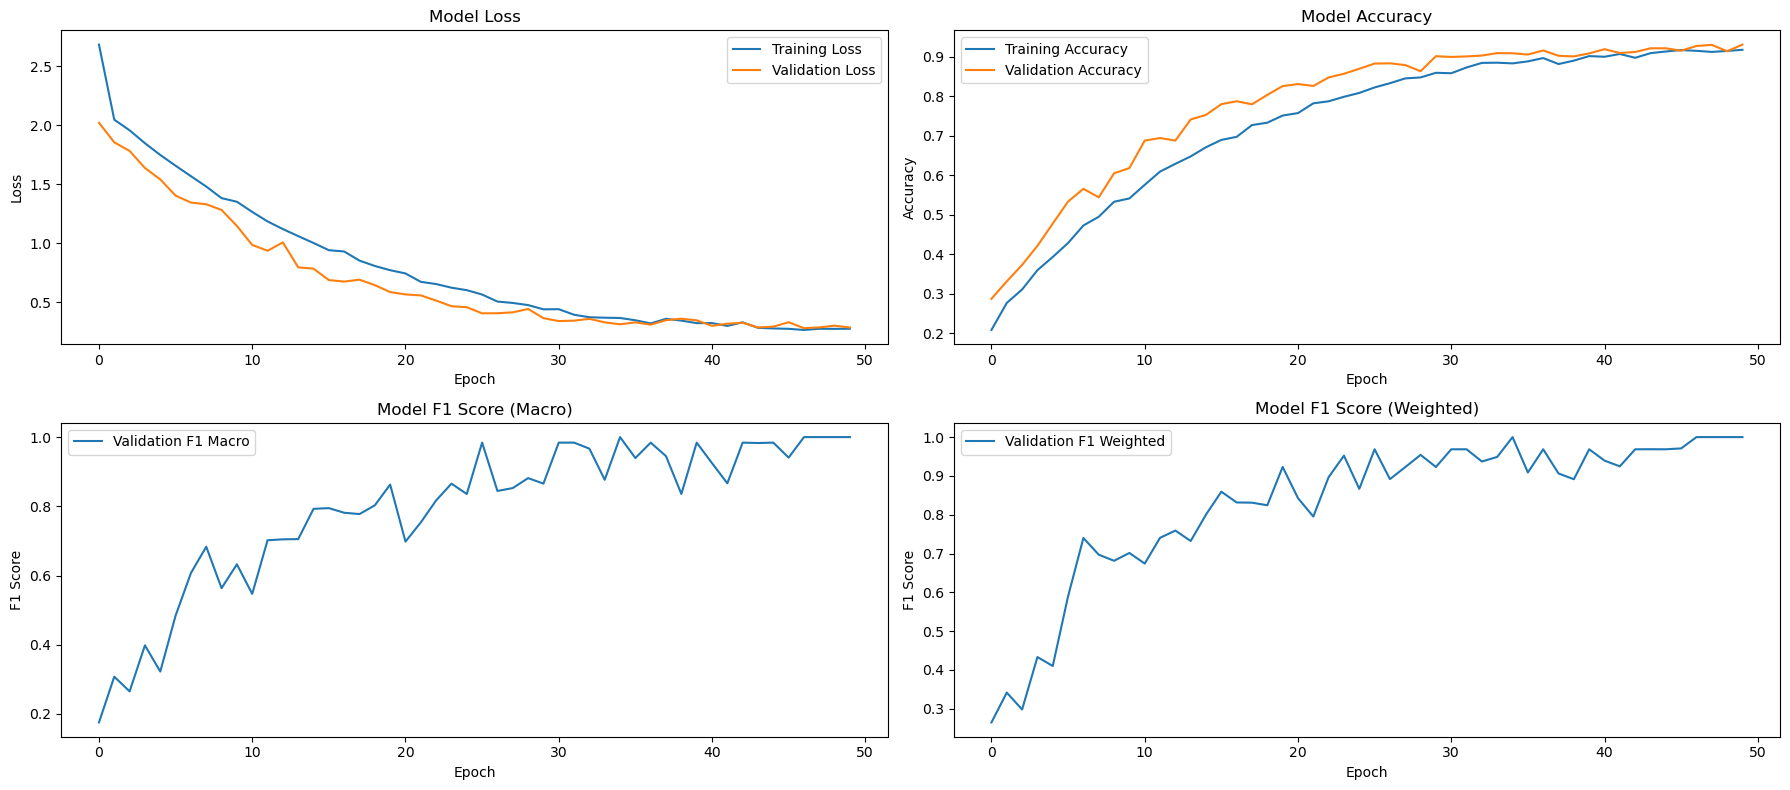

Creating test dataset...
Generating predictions...
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step
Predictions saved to 'label_predictions_with_f1.csv'
Detailed predictions saved to 'label_predictions_detailed_with_f1.csv'


In [ ]:
history = train_label_model(vit_label_classifier)  # Train the model

# Save the trained model and weights
vit_label_classifier.save(FINAL_MODEL_PATH)
vit_label_classifier.save_weights(FINAL_WEIGHTS_PATH)

# Function to plot training curves
def plot_training_curves(history):
    """Plot training and validation loss, accuracy, and F1 scores.
    Args:
        history: Training history object from model.fit.
    """
    plt.figure(figsize=(18, 8))
    
    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot validation macro F1 score
    plt.subplot(2, 2, 3)
    plt.plot(history.history['val_f1_macro'], label='Validation F1 Macro')
    plt.title('Model F1 Score (Macro)')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot validation weighted F1 score
    plt.subplot(2, 2, 4)
    plt.plot(history.history['val_f1_weighted'], label='Validation F1 Weighted')
    plt.title('Model F1 Score (Weighted)')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves_with_f1.png')  # Save plot to file
    plt.show()

# Plot training curves
plot_training_curves(history)